# DM-38894  investigate fit residuals in ts_wep

Author: Chris Suberlak ([@suberlak](https://github.com/lsst-sitcom/sitcomtn-072/issues/new?body=@suberlak))

Software Versions:

* ts_wep: **v6.0.2**
* lsst_distrib: **w_2023_16**

Last verified to run: 4/26/2023

Based on `AOS_AuxTel_test_data_210608_434-471.ipynb`. The wavefront surface model is not stored by the AOS. But we can evaluate it given the Zks, and plot next to the donut image. 

Take any auxTel data that was recently fit with  ts_wep:

In [2]:
import numpy as np
import os 
from lsst.ts.wep.cwfs.tool import ZernikeAnnularFit, ZernikeEval, ZernikeAnnularEval
from lsst.ts.wep.cwfs.instrument import Instrument
from lsst.ts.wep.utility import getModulePath, getConfigDir
from lsst.ts.wep.utility import DefocalType, CamType
from astropy.visualization import ZScaleInterval
from lsst.daf.butler import Butler

output_collection = 'u/scichris/latiss_230310_run/wep_with_transpose_'
butler = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)


INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/s/scichris/.lsst/aws-credentials.ini


In [14]:
# for x-offsets
dxs = np.linspace(-2, 2, 10) # mm 
intra_seq_nums = np.arange(71, 90, 2)
j=0
seq_num = intra_seq_nums[j]
dx = dxs[j]
dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
zk =  butler.get("zernikeEstimateAvg", dataId=dataId
               )
        

In [5]:
donutStampIntra = butler.get("donutStampsIntra", dataId=dataId)

In [6]:
donutStampExtra = butler.get("donutStampsExtra", dataId)

Text(0.5, 1.0, 'extra')

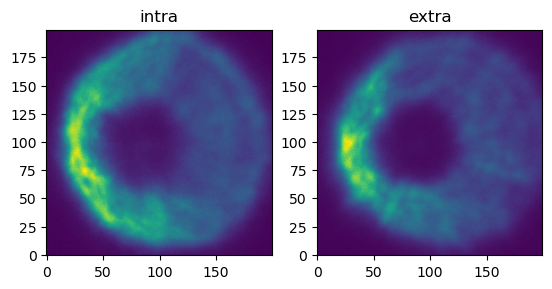

In [11]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2)

ax[0].imshow(donutStampIntra[0].stamp_im.image.array, origin='lower')
ax[1].imshow(donutStampExtra[0].stamp_im.image.array, origin='lower')
ax[0].set_title('intra')
ax[1].set_title('extra')

Text(0.5, 1.0, 'dx= -2.0[mm]')

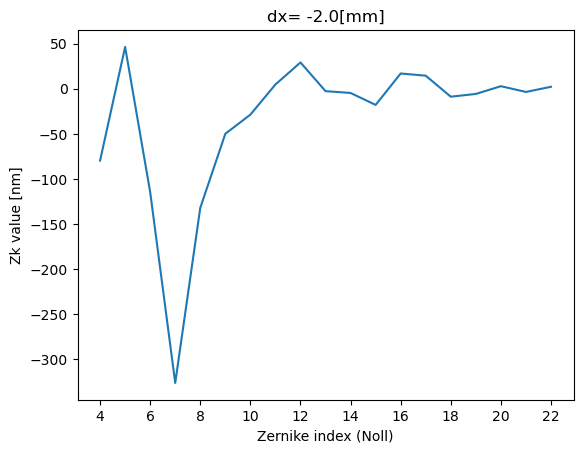

In [15]:
plt.plot(np.arange(4,23), zk*1e3)
plt.xticks(np.arange(4, 23, 2))
plt.ylabel('Zk value [nm]')
plt.xlabel("Zernike index (Noll)")#, ylabel="$\mu m$")
plt.title(f'dx= {dx} [mm]')

`ZernikeAnnularEval` uses `galsim.zernike.Zernike`  https://github.com/lsst-ts/ts_wep/blob/138b2c75876ccb71f0b955a8fed91ccf0d15319f/python/lsst/ts/wep/cwfs/tool.py#L41, padding with an extra 0 at the beginning, so that array[N]  is the N-th zernike (eg. array[5] is zk5, so the array starts from zk0, which is unused)...

In [51]:
from galsim.zernike import Zernike as GSZernike

Text(0.5, 1.0, 'residuals (model-data)')

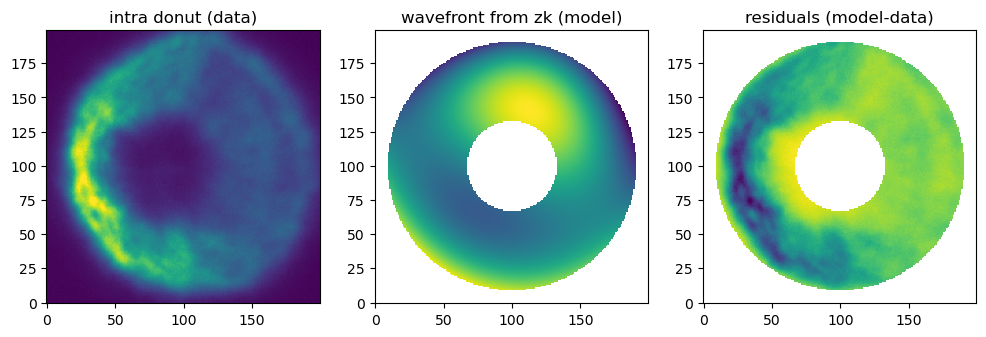

In [54]:
# Evaluate the wavefront given the annular zernikes: 
# get the sensor annular coordinates 
sizeInPix = np.shape(donutStampIntra[0].stamp_im.image.array)[0] # 200 for auxTel  - donut stamp size 
camType=CamType.AuxTel

cwfsConfigDir = os.path.join(getConfigDir(), "cwfs")
instDir = os.path.join(cwfsConfigDir, "instData")

inst = Instrument()
dimOfDonutImgOnSensor = sizeInPix
instConfigFile = os.path.join(getConfigDir(), 'cwfs', 'instData', 'auxTel','instParamPipeConfig.yaml')
inst.configFromFile(dimOfDonutImgOnSensor, camType, instConfigFile)

xoSensor, yoSensor = inst.getSensorCoorAnnular()

# need to pad with zeros, the zernikes need to be converted
# from microns to meters 
zk_pad = np.concatenate((np.zeros(3), zk*1e-6))

# evaluate on a grid of x,y positions for annular sensr 
# 
waveFromZk = ZernikeAnnularEval(zk_pad, xoSensor, yoSensor, inst.obscuration )

# do the plotting for intra-focal donut stamp
fig,ax = plt.subplots(1,3,figsize=(12,4))

zscale = ZScaleInterval()
data = donutStampIntra[0].stamp_im.image.array
vmin,vmax = zscale.get_limits(data)

ax[0].imshow(data, vmin=vmin, vmax=vmax, origin='lower')
ax[0].set_title('intra donut (data)')

ax[1].imshow(waveFromZk, origin='lower' )
ax[1].set_title('wavefront from zk (model)', )

ax[2].imshow(waveFromZk-data,origin='lower')
ax[2].set_title('residuals (model-data)', )

#fig.suptitle(f'{delname}={delta} (mm), exp {exp}, donut{idx}')

In [55]:
zk_pad

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.96785193e-08,
        4.62692024e-08, -1.14604793e-07, -3.26003927e-07, -1.31993503e-07,
       -4.99576647e-08, -2.87613392e-08,  4.64927264e-09,  2.90498038e-08,
       -2.71375590e-09, -4.74757895e-09, -1.79591314e-08,  1.68372415e-08,
        1.43901777e-08, -8.87411346e-09, -5.82598991e-09,  2.76513401e-09,
       -3.62190616e-09,  2.09921284e-09])

## Try Algorithm.getLog()

Algorithm now has logging. Can the stored quantities help with an estimate of how well has the algorithm reached convergence ? 

https://github.com/lsst-ts/ts_wep/pull/152

https://jira.lsstcorp.org/browse/DM-36154

The problem is that these quantities are not stored when running `wep` as a pipetask. So I can't pull the `log` from butler.  It can be obtained only if running `Algorithm` directly by `getLog` ... Try: 

https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/task/calcZernikesTask.py  calls https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/wfEstimator.py So replicate here whatever settings `wfEstimator` passes to `Algorithm` use the `postISR` donut postage stamps as above to feed the algorithm.. 

In [74]:
stampExtra = donutStampExtra[0]
stampIntra = donutStampIntra[0]

In [90]:
# from https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/wfEstimator.py 
from lsst.ts.wep.cwfs.instrument import Instrument
from lsst.ts.wep.cwfs.algorithm import Algorithm
from lsst.ts.wep.cwfs.compensableImage import CompensableImage
from lsst.ts.wep.utility import (
    DefocalType,
    CamType,
    CentroidFindType,)

configDir = getConfigDir()
algoDir = os.path.join(configDir, "cwfs", "algo")
inst = Instrument()
algo = Algorithm(algoDir)

solver="exp"
camType=CamType.AuxTel
opticalModel="onAxis"
sizeInPix=200
centroidFindType=CentroidFindType.RandomWalk
debugLevel=1

inst.configFromFile(sizeInPix, camType)

algo.config(solver, inst, debugLevel=debugLevel)

imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)

# NB. no rotation here, but for corner sensors that would be necessary ... 
imgIntra.setImg(
            stampIntra.calcFieldXY(),
            DefocalType.Intra,
            blendOffsets=None,
            image=stampIntra.stamp_im.image.array,
        )

imgExtra.setImg(
            stampExtra.calcFieldXY(),
            DefocalType.Extra,
            blendOffsets=None,
            image=stampExtra.stamp_im.image.array,
        )



In [91]:
# Calculate the wavefront error.
# Run cwfs
algo.runIt(imgIntra, imgExtra, opticalModel, tol=1e-3)

In [147]:
zk4upNm = algo.getZer4UpInNm()

In [148]:
zk4upNm

array([ -79.67851925,   46.26920239,  114.60479342, -131.99350298,
       -326.0039265 ,   28.76133923,   49.9576647 ,    4.64927264,
        -29.04980383,   -2.7137559 ,   -4.74757895,   17.95913141,
         14.39017766,   16.83724146,    5.82598991,    8.87411346,
         -3.62190616,    2.76513401,    2.09921284])

The algorithm history is only accessible if we set debug level to 1 :

In [95]:
history = algo._history

In [151]:
len(history[i]['residZk'])

22

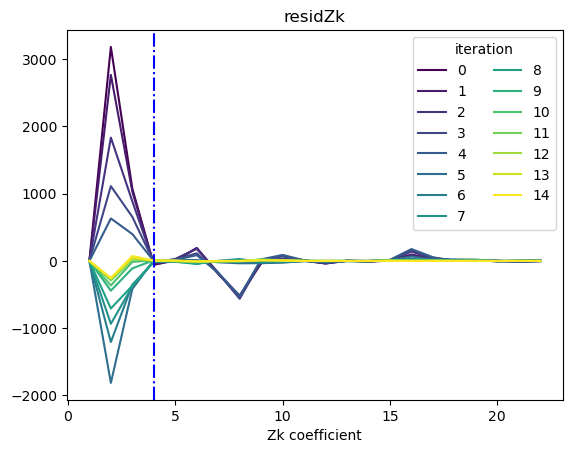

In [172]:
nlines = len(history)
color_idx = np.linspace(0, 1, nlines)
cmap = plt.cm.viridis
fig,ax = plt.subplots(1,1)
for i in range(len(history)):
    color = cmap(color_idx[i])
    ax.plot(np.arange(1,23), history[i]['residZk'], c=color, label=i)
ax.set_xlabel('Zk coefficient')
ax.legend(title='iteration', bbox_to_anchor=[1, 1.0], ncol=2)
ax.set_title('residZk')
ax.axvline(4,c='b',ls='-.')

It's interesting that Zk 2 changes so much, even though it's not returned in the final result... Zoom in on Zk4 up:

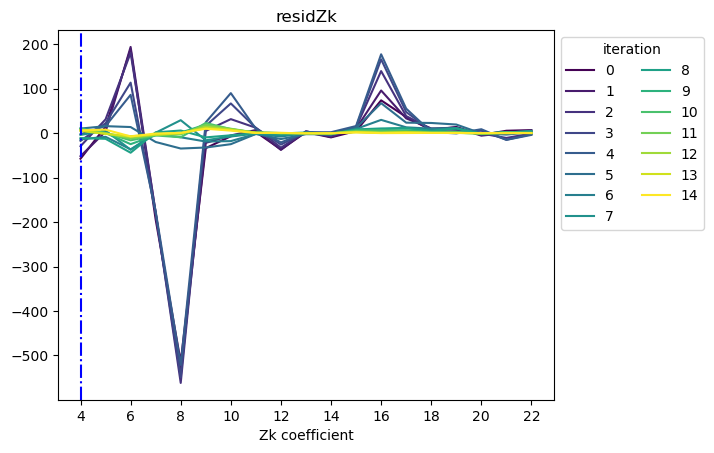

In [171]:
nlines = len(history)
color_idx = np.linspace(0, 1, nlines)
cmap = plt.cm.viridis
fig,ax = plt.subplots(1,1)
for i in range(len(history)):
    color = cmap(color_idx[i])
    ax.plot(np.arange(4,23), history[i]['residZk'][3:], c=color, label=i)
ax.set_xlabel('Zk coefficient')
ax.legend(title='iteration', bbox_to_anchor=[1, 1.0], ncol=2)
ax.set_title('residZk')
ax.axvline(4,c='b',ls='-.')
ax.set_xticks(range(4,24)[::2])

I do understand that residuals get smaller, which is good (a sign of convergence... ) 

Plot the `totZk`  - this is the `converge[:, jj].copy() * 1e9` , i.e. exactly what's returned in the  final iteration. So the 14th `totZk` should be the same as 

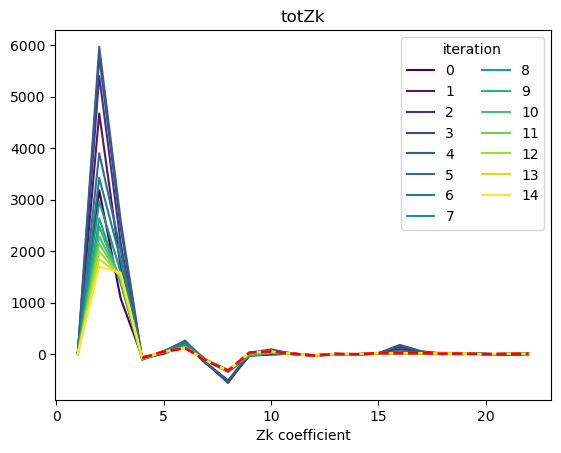

In [175]:
nlines = len(history)
color_idx = np.linspace(0, 1, nlines)
cmap = plt.cm.viridis
fig,ax = plt.subplots(1,1)
quant = 'totZk'
for i in range(len(history)):
    color = cmap(color_idx[i])
    ax.plot(np.arange(1,23), history[i][quant], c=color, label=i)
ax.set_xlabel('Zk coefficient')
ax.legend(title='iteration', bbox_to_anchor=[1, 1.0], ncol=2)
ax.set_title(quant)
ax.plot(np.arange(4,23), zk4upNm,c='r', lw=2, ls='--')

zoom-in:

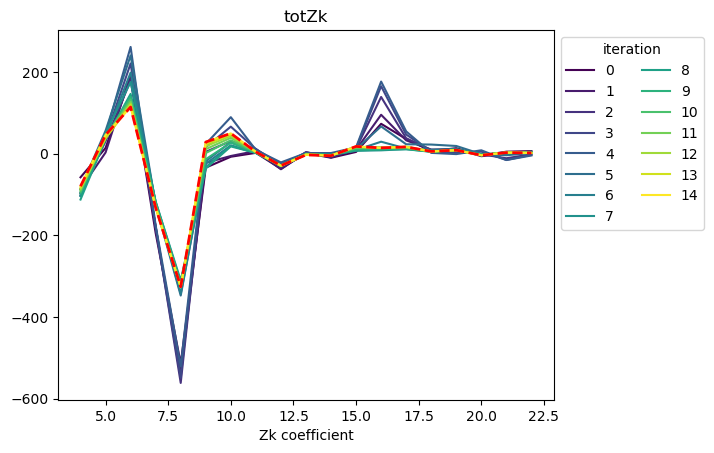

In [174]:
nlines = len(history)
color_idx = np.linspace(0, 1, nlines)
cmap = plt.cm.viridis
fig,ax = plt.subplots(1,1)
quant = 'totZk'
for i in range(len(history)):
    color = cmap(color_idx[i])
    ax.plot(np.arange(4,23), history[i][quant][3:], c=color, label=i)
ax.set_xlabel('Zk coefficient')
ax.legend(title='iteration', bbox_to_anchor=[1, 1.0], ncol=2)
ax.set_title(quant)

ax.plot(np.arange(4,23), zk4upNm,c='r', lw=2,ls='--')

Text(0.5, 1.0, 'totWf')

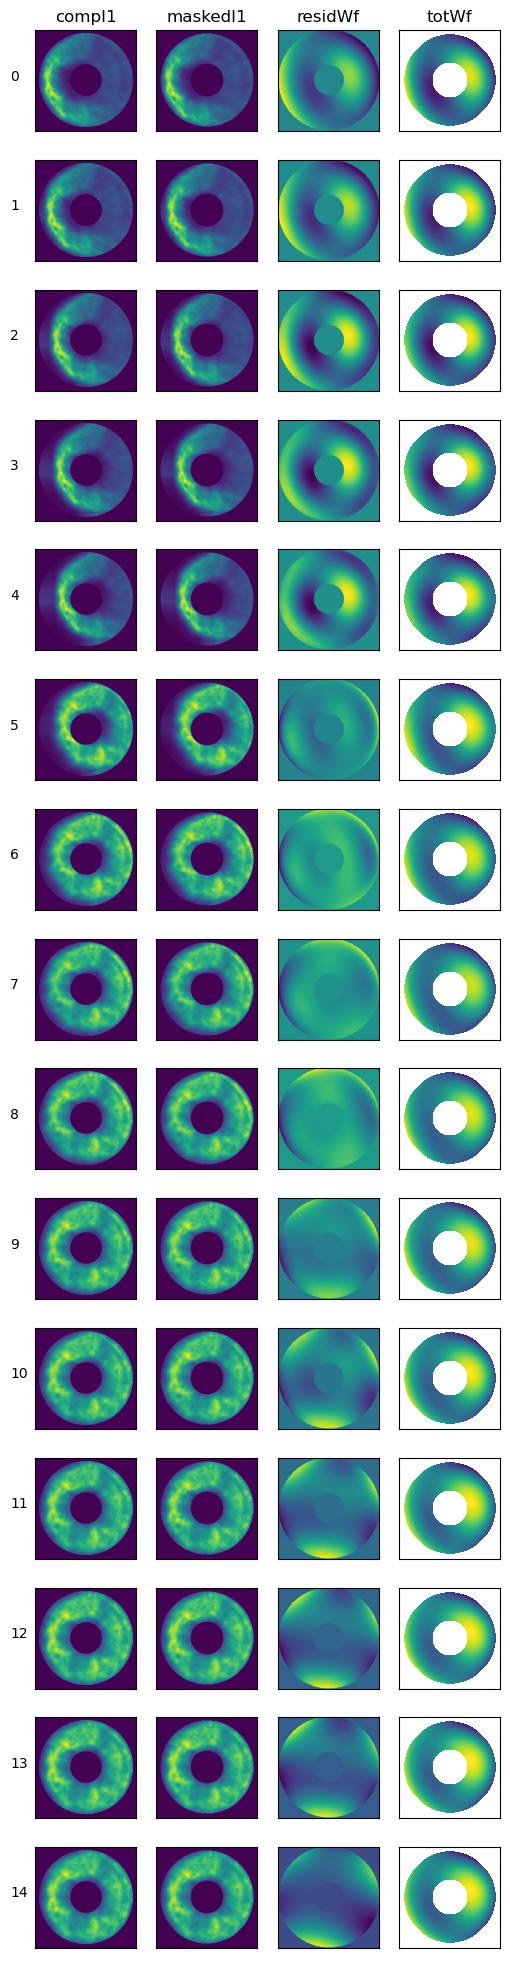

In [187]:
to_plot = ['compI1','maskedI1', 'residWf', 'totWf']
ncol = len(to_plot)
fig,ax = plt.subplots(15,ncol, figsize=(ncol*1.5,25))

for i in range(len(history)):
    #  Remove the image distortion by forwarding the image to pupil 
    # the "compensated" image is the image forwarded to the pupil... 
    col = 0 
    ax[i,col].text(-50,100,i)
    for quantity in to_plot:
        ax[i,col].imshow(history[i][quantity], origin='lower') 
        ax[i,col].set_yticklabels([])
        ax[i,col].set_yticks([])
        ax[i,col].set_xticklabels([])
        ax[i,col].set_xticks([])
        col += 1 

ax[0,0].set_title('compI1')
ax[0,1].set_title('maskedI1')
ax[0,2].set_title('residWf')
ax[0,3].set_title('totWf')



The rows are numbered by iteration, progressing from top to bottom (the last row is the final iteration). 

Plot the `totZk` and the `residZk` from the last iteration: 

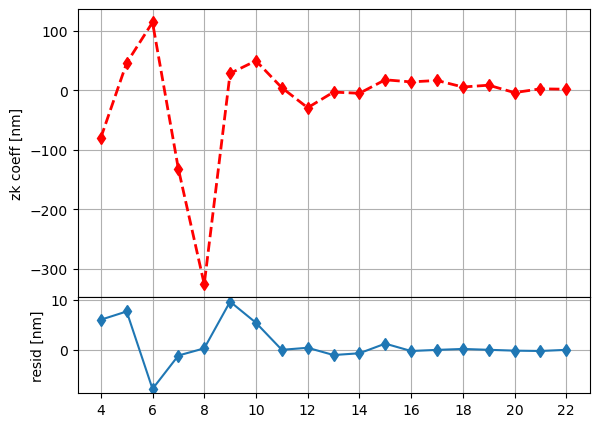

In [210]:
resid = history[14]['residZk'][3:]
fig = plt.figure()
ax=fig.add_axes((.1,.3,.8,.6))
ax.plot(np.arange(4,23), zk4upNm, c='r', marker='d', lw=2,ls='--')
ax.set_xticklabels([])
ax.set_ylabel('zk coeff [nm]')
ax.set_xticks(range(4,24)[::2])
ax.grid()
ax1 = fig.add_axes((.1,.1,.8,.2))
ax1.plot(np.arange(4,23), resid, marker='d')
ax1.set_ylabel('resid [nm]')
ax1.grid()
ax1.set_xticks(range(4,24)[::2])

Residuals are not differences between model and data. They are actually incremental small perturbations added at each step of the iteration.  That's why `residZk` gets smaller and smaller as the simulation converges, and `totZk` approach the final reported fit value. 